# Lab 2: Classification

* Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All

* If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

# Part 1. Multiclass logistic regression

### Overview

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

## Dataset

In [3]:
!pwd
!ls

/mnt/54dffebc-9729-4262-8fa6-4a168d91adfe/Github/Machine learning 1 - Assignments/assign_2
'Assignment 2.ipynb'   openml


In [1]:
# Download the dataset 

from sklearn.datasets import fetch_openml
import os 

try: 
    mnist = fetch_openml(name='mnist_784', data_home='.')
except:
    raise FileNotFoundError("Unable to download the file")

In [2]:
data, target = mnist.data, mnist.target.astype('int')

In [3]:
# shuffle 
import numpy as np 

indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices] 

# normalize the data b/w [0.0, 1.0]
data /= 255.0 

# split 
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000:70000]
t_train, t_valid, t_test =  target[:50000], target[50000:60000], target[60000:70000] 

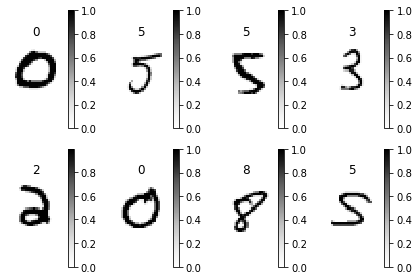

In [4]:
import matplotlib.pyplot as plt 

def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

## Theory

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient based stochastic optimisation

### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

#### A) 

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.

#### Solution A ) 
 
> For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&=1-Z^{-1}e^{\log(q_j)}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&=-Z^{-1}e^{\log(q_j)}
\end{align}


#### B) 
Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

#### Solution B)



>$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}} 
= \mathbf{\delta}_j^q \frac{\partial W_j^TX + b_j}{\partial W_{ij}} 
= \mathbf{\delta}_j^q \frac{\partial \sum_kw_{kj}x_k + b_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q x_i
$

>$
\nabla_{w_j}\mathcal{L}^{(n)} = (\mathbf{\delta}_j^q*x^{(\mathbf{n})})^T
$

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow \log Z \rightarrow \log \bp\,,\, \rightarrow \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [5]:
def logreg_gradient(x, t, w, b):
    
    # find the log q 
    # x : [1, 784]
    # w : [784, 10]
    # output : [1, 10]
    # add bias b : [10, ]
    # output : [1, 10]
    log_q = np.dot(x, w) + b 
#     print(log_q.shape)
    
    # find log z 
    # output : scalar number 
    max_log_q = np.max(log_q)
    log_Z = max_log_q + np.log( np.sum( np.exp(log_q - max_log_q) ))
#     print(log_Z)

    # find log p 
    log_p = log_q - log_Z 
    
    # find del_q 
    # q1 : shape ? -> same as log_q
    del_q = np.zeros_like(log_q)
    # q2 : conditioned on t 
    del_q[:, t] = 1
    del_q -= np.exp(log_q - log_Z)
#     print(del_q.shape)
    
    # d_b 
    dL_by_db = del_q
    
    # d_w 
    dL_by_dw = x.T.dot(del_q)
#     print(dL_by_dw.shape)

    return log_p[:, t].squeeze(), dL_by_dw, dL_by_db.squeeze()     

[why to use seed](https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do)

In [6]:
# create dataset for testing 
np.random.seed(123)

w = np.random.normal(size=(784, 10), scale=0.001)
b = np.zeros((10, ))
temp_x = x_train[0:1, :]
temp_t = t_train[0:1]

print(f'''w : {w.shape}, 
          b : {b.shape}
          x : {temp_x.shape}
          t : {temp_t.shape}
          ''')

log_p_t, dL_by_dw, dL_by_db = logreg_gradient(temp_x, temp_t, w, b)
print(f'''
        log_p_t : {log_p_t}
        dL_by_dw : {dL_by_dw.shape}
        dL_by_db : {dL_by_db.shape}
        ''')

w : (784, 10), 
          b : (10,)
          x : (1, 784)
          t : (1,)
          

        log_p_t : -2.296585968775302
        dL_by_dw : (784, 10)
        dL_by_db : (10,)
        


In [7]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt

def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()

finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt

def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()

finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'

Finite difference error grad_w: 4.887373553714918e-07
Finite difference error grad_b: 1.982092717653279e-08


### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [8]:
from tqdm import tqdm 

def sgd_iter(x_train, t_train, W, b):
    """
    runs an epoch over the dataset.
    - ensure dataset is randomized before moving further
    
    equation :
     W = W + lr * dL_by_dW
     b = b + lr * dL_by_db 
    """
    # randomize the dataset
    indices = np.array([x for x in range(0, x_train.shape[0])])
    np.random.shuffle(indices)
    
    # learning rate
    lr = 1e-4
    
    # an estimate of likelihood of epoch
    logp_train = 0.0 
    
    for index in tqdm(indices, position=0):
        log_pt, grad_w, grad_b = logreg_gradient(x_train[index:index+1, :], t_train[index:index+1], W, b)
        
        # update weights
        W += lr * grad_w 
        b += lr * grad_b 
        logp_train += log_pt 
    
    # normalize the logp_train
    logp_train /= x_train.shape[0]
    
    return logp_train, W, b
    

In [9]:
# Sanity check on small dataset
np.random.seed(1243)
w = np.zeros((784, 10))
b = np.zeros(10)
# print(w.shape, b.shape)
logp_train, w, b = sgd_iter(x_train[:100], t_train[:100], w, b)

100%|██████████| 100/100 [00:00<00:00, 12998.74it/s]


## 1.2. Train

### 1.2.1 Train (12 points)
- Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

- Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

- Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

In [10]:
import matplotlib.pyplot as plt

def plot(training, validation, val_accuracies, train_accuracies, iterations):
    
#     plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.plot(iterations, training, label="training")
    plt.plot(iterations, validation, label="validation")
    plt.xlabel = "iterations"
    plt.ylabel = "log p probabilities"
    plt.legend()
    plt.title("log p graphs")
    
    plt.subplot(1,2,2)
    plt.plot(iterations, val_accuracies, label="validation accuracy")
    plt.plot(iterations, train_accuracies, label="train accuracy")
    plt.xlabel = "iterations"
    plt.ylabel = "accuracies"
    plt.title("accuracies graphs")
    
    plt.legend()
    plt.show()

[0 1 2 3 4 5 6 7 8 9]


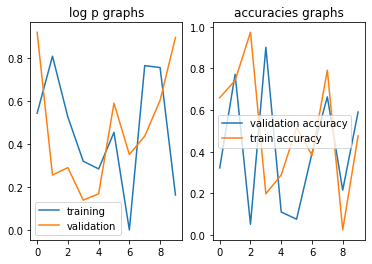

In [11]:
iterations = np.arange(0, 10,1)
print(iterations)
training = np.random.rand(10)
validation = np.random.rand(10)
train_accuracies = np.random.rand(10)
validation_accuracies = np.random.rand(10)

plot(training, validation, validation_accuracies, train_accuracies, iterations)

In [12]:
# define validation
def inference(x, w, b):
    """
    inference on single examples
    """
    log_q = np.dot(x, w) + b 
    max_log_q = np.max(log_q)
    log_Z = max_log_q + np.log( np.sum( np.exp(log_q - max_log_q) ))
    log_p = log_q - log_Z 
    return log_p

def validate(x_valid, t_valid, w, b):
    log_p_valid = 0.0
    correct_counts = 0
    
    # loop over each
    for j in range(x_valid.shape[0]):
        
        # get log likedlihood 
        log_p = inference( x_valid[j:j+1, :], w, b)
        
        # target
        target = t_valid[j]
        
        # update total likelihood
        log_p_valid += log_p[0, target]
        
        # predicted label
        predicted = np.argmax(log_p, axis=1)[0]
        correct_counts += (target == predicted )
        
    # accuracy 
    accuracy = correct_counts / x_valid.shape[0]
    
    # normalise the log likelihood
    log_p_valid = log_p_valid / x_valid.shape[0]
    
    return log_p_valid, accuracy 

In [61]:
# np.random.seed(1243)
w = np.random.randn(784, 10)
b = np.zeros(10)
log_p_valid, val_accuracy = validate(x_valid, t_valid, w, b)

print(f"Accuracy : {val_accuracy}, log_p_valid : {log_p_valid}")

Accuracy : 0.1526, log_p_valid : -11.393842919244019


In [13]:
def test_sgd(x_train, t_train, x_valid, t_valid, w, b, epsilon = 10.0):
    difference = 1000.0 
    t_logp, v_logp = [], []
    
    v_accuracies = [] 
    t_accuracies = [] 
    
    iterations = [] 
    i = 1 
    
    while difference > epsilon:
        old_w = w.copy()
        old_b = b.copy()
        
        i_logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        i_logp_valid, val_accuracy = validate(x_valid, t_valid, w, b) 
        _, train_accuracy = validate(x_train, t_train, w, b)
        
        # update log likelihoods
        t_logp.append(i_logp_train)
        v_logp.append(i_logp_valid) 
        
        # update accuracies
        v_accuracies.append(val_accuracy)
        t_accuracies.append(train_accuracy)
        
        # iterations count 
        iterations.append(i)
        
        difference = np.sum(np.abs(old_w-w))
        difference += np.sum(np.abs(old_b-b))
        i += 1
        print(f"difference : {difference}, train : {train_accuracy}, validation : {val_accuracy}")
    
    # plot
    plot(t_logp, v_logp, v_accuracies, t_accuracies, iterations)
    return w, b 
        

  2%|▏         | 1187/50000 [00:00<00:04, 11868.23it/s]

difference : 125.43220046626652, train : 0.83984, validation : 0.8423


  2%|▏         | 1212/50000 [00:00<00:04, 12119.03it/s]

difference : 48.48366480165512, train : 0.86122, validation : 0.863


  2%|▏         | 905/50000 [00:00<00:05, 9047.83it/s]

difference : 31.518757723591712, train : 0.87014, validation : 0.8722


  3%|▎         | 1264/50000 [00:00<00:03, 12636.91it/s]

difference : 23.901947451740828, train : 0.87746, validation : 0.8787


  2%|▏         | 1130/50000 [00:00<00:04, 11295.32it/s]

difference : 19.56607495268548, train : 0.88256, validation : 0.8826


  2%|▏         | 891/50000 [00:00<00:05, 8906.53it/s]

difference : 16.658744974912587, train : 0.88558, validation : 0.8857


  2%|▏         | 1168/50000 [00:00<00:04, 11672.55it/s]

difference : 14.641357494206922, train : 0.88872, validation : 0.8885


  2%|▏         | 1124/50000 [00:00<00:04, 11236.13it/s]

difference : 13.07775934398974, train : 0.8909, validation : 0.8904


  2%|▏         | 1150/50000 [00:00<00:04, 11495.35it/s]

difference : 11.99936263481244, train : 0.89276, validation : 0.8926


  2%|▏         | 1153/50000 [00:00<00:04, 11528.09it/s]

difference : 10.94372517189968, train : 0.89436, validation : 0.8939


  2%|▏         | 1131/50000 [00:00<00:04, 11303.65it/s]

difference : 10.211355094804452, train : 0.89678, validation : 0.8951


100%|██████████| 50000/50000 [00:04<00:00, 11307.27it/s]


difference : 9.604639608784108, train : 0.89764, validation : 0.8965


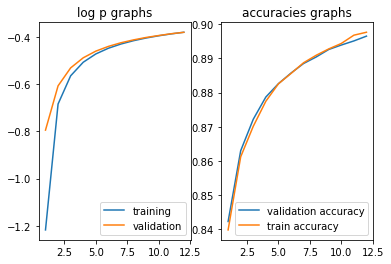

In [24]:
np.random.seed(1243)
w = np.zeros((784, 10))
b = np.zeros(10)
w, b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


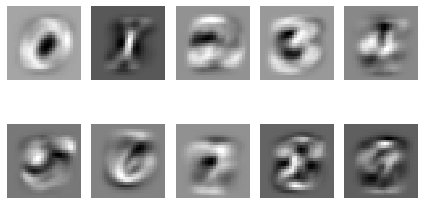

In [25]:
def plot_digits(data, num_cols, targets = None, shape=(28, 28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits / num_cols )
    for i in range( num_digits ):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='gray')
        
        if targets is not None:
            plt.title(int(targets[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show() 
    
# if weights were initialised as randn or rand, the image might not look good but accuracy will be high.
# you can see the reason logically, the update of weights will make weights learned but maybe the interpretation 
# is hard. 
# to visualise better you may use some tactics of appraximations over weights to threshold. 
# better is  to initialise by zeros.
# so that everything is start is 0 and updates are not that much noisy for each pixel. 

plot_digits(w.T, num_cols = 5)

**Describe in less than 100 words why these weights minimize the loss**

for each class of images ( 10 here ), there is a 784 weights. now after visualisation you can see the weights in the area of interest are high - represented by white and in other part low - grey or black. 

Thus weights represent the contribution of each feature towards the classification. Higher weights means higher contribution to the decision.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.

In [76]:
def inference2(x, w, b):
    """
    inference on single examples
    """
    log_q = np.dot(x, w) + b 
    max_log_q = np.max(log_q)
    log_Z = max_log_q + np.log( np.sum( np.exp(log_q - max_log_q) ))
    log_p = log_q - log_Z 
    return log_p

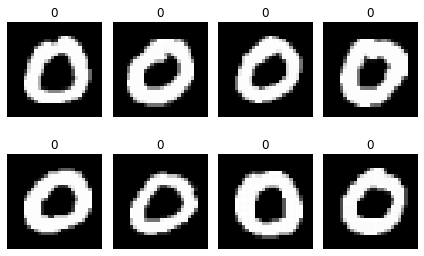

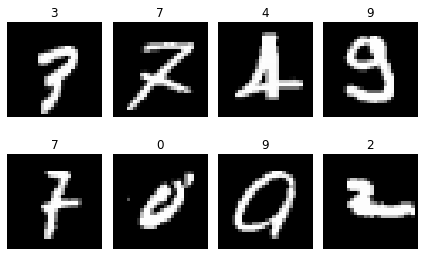

In [81]:
def visualize(x_valid, t_valid, w, b):
    prob = []
    true_classes = []
    for i in range(0, len(x_valid)):
        logp = inference(x_valid[i:i+1, :],t_valid[i:i+1], w, b)
        prob.append( (logp, t_valid[i:i+1], x_valid[i:i+1, :]) )
        
    worst = sorted(prob, key = lambda x:x[0])[0:8]
    best = sorted(prob, key = lambda x:x[0], reverse=True)[0:8]
    
    best_digits = np.array( [ x[2][0] for x in best ])
    best_targets = np.array([ x[1][0] for x in best ])
    plot_digits(best_digits, 4, best_targets)
    
    worst_digits = np.array([x[2][0] for x in worst])
    worst_targets = np.array([x[1][0] for x in worst])
    plot_digits(worst_digits,4,targets=worst_targets)
    
    
visualize(x_valid, t_valid, w, b)

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

>  Your Answer

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

For determining the maximum a posteriori solution we must also determine the parameters for the gaussian prior which would tell us how likely each class it is. Thus, would to find the optimal mean and variance for this prior. Also we would do these calculations in the logaritmic space for making them simpler. The only diffrence this time would be that we will not derivate only after $\mathcal{L}^{(n)}$ but by $\mathcal{L}^{(n)}$ times the gaussian prior. We would not take account of the evidence as it is not influenced by any of this parameters.

## 2.3. Implement and train a MLP (15 points)

- Implement an MLP model with a single hidden layer of **20 neurons**. 
- Train the model for **10 epochs**.
- Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and 
- plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [87]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

def mlp_gradient(x, t, W, b, V, a):
    
    # forward computation
    h = sigmoid ( x.dot(V) + a)
    log_q = h.dot(W) + b 
    max_log_q = np.max(log_q)
    log_z = max_log_q + np.log( np.sum ( np.exp( log_q - max_log_q) ) ) 
    z = np.exp(log_z)
    
    # backward computation
    grad_b = np.zeros_like(log_q) 
    grad_b[0][t[0]] = 1
    grad_b -= np.exp(log_q) / z 
    
    grad_w = np.matmul ( np.transpose(h), grad_b )
    
    grad_h = np.matmul ( grad_b, np.transpose(W) )
    grad_a = grad_h * h * (1 - h)
    
    grad_v = np.matmul ( np.transpose(x), grad_a )
    log_p = log_q - log_z 
    
    return log_p[:, t].squeeze(), grad_v, grad_a.squeeze(), grad_w, grad_b.squeeze() 
    

In [88]:
# test mlp gradient 
hidden_units = 20 
x = x_train[0:1, :] ; print(x.shape)
t = t_train[0:1,] ; print (t.shape)
v = np.zeros((784, 20))
a = np.zeros((20,))
w = np.zeros((20, 10))
b = np.zeros((10,))
log_p, grad_v, grad_a, grad_w, grad_b = mlp_gradient(x, t, w, b, v, a)

print(grad_v.shape, grad_a.shape, grad_w.shape, grad_b.shape, type(log_p), log_p.shape, log_p )

(1, 784)
(1,)
(784, 20) (20,) (20, 10) (10,) <class 'numpy.ndarray'> () -2.302585092994046


In [90]:
from tqdm import tqdm 

def sgd_mlp_iter(x_train, t_train, v, a, w, b, lr ):
    idx = list ( range ( len(x_train) ))
    np.random.shuffle(idx) 
    
    logp_train = 0 
    for i in tqdm(idx, position=0, desc= "training :"):
        logpt, grad_v, grad_a, grad_w, grad_b = mlp_gradient(x_train[i:i+1, :], 
                                                             t_train[i:i+1,], 
                                                             w, b, v, a)
        logp_train += logpt 
        v += lr * grad_v 
        a += lr * grad_a 
        w += lr * grad_w
        b += lr * grad_b
        
    return logp_train, v, a, w, b

In [92]:
# test mlp gradient 
hidden_units = 20 
x = x_train[0:1, :]
t = t_train[0:1,]
v = np.zeros((784, 20))
a = np.zeros((20,))
w = np.zeros((20, 10))
b = np.zeros((10,))

# log_p, grad_v, grad_a, grad_w, grad_b = mlp_gradient(x, t, w, b, v, a)
# print(grad_v.shape, grad_a.shape, grad_w.shape, grad_b.shape, type(log_p), log_p.shape )

logp_train, v, a, w, b = sgd_mlp_iter(x_train, t_train, v, a, w, b, lr = 0.001)

training :: 100%|██████████| 50000/50000 [00:08<00:00, 5986.71it/s]


In [103]:
def plot_weights( halves, num_cols, targets = None, shape = (28, 28)):
    
    plt.figure(figsize=(20,20))
    num_digits = halves[0].shape[1]
    num_rows = int ( num_digits / num_cols )
    
    for w in halves : 
        for i in range(num_digits):
            plt.subplot(2, num_digits//2, i+1)
            plt.imshow(w[:, i].reshape(shape), interpolation='None', cmap='gray')
            if targets is not None:
                plt.title(f"Weight {i}", fontsize=11, fontweight='bold')
            plt.colorbar()
            plt.axis('off')
            i+= 1 
        plt.tight_layout()
        plt.show()

In [94]:
def mlp_compute_loss( x, t, v, a, w, b):
    h = sigmoid( x.dot(v) + a)
    log_q = h.dot(w)+b 
    max_log_q = np.max(log_q, axis = 1)
    log_Z = max_log_q[:, np.newaxis] + np.log(np.sum(np.exp(log_q - max_log_q[:, np.newaxis]), axis = 1))[:, np.newaxis]
    
    logp = log_q - log_Z 
    return logp[:, t].squeeze()

In [98]:
def test_mlp(x_train, t_train, x_valid, t_valid, v, a, w, b, lr, nr_iters):
    
    train_loss = np.zeros((nr_iters))
    val_loss = np.zeros((nr_iters))
    
    for i in tqdm( range(nr_iters), position = 1, desc = "epochs :" ) :  
        loss, v, a, w, b = sgd_mlp_iter(x_train, t_train, v, a, w, b, lr)
        
        train_loss[i] = loss/len(x_train)
        val_loss[i] = np.sum(mlp_compute_loss(x_valid,t_valid,v,a,w,b)) / len(x_valid) 
        
        if lr == 1e-2 and (i == 0 or i== 4 or i==9):
            print('Weights plots of iteration: ' + str(i))
            halves = np.split(v, 2, 1)
            plot_weights(halves, 5)
            
    return train_loss, val_loss

In [99]:
# test mlp gradient 
hidden_units = 20 
x = x_train[0:1, :]
t = t_train[0:1,]
v = np.zeros((784, 20))
a = np.zeros((20,))
w = np.zeros((20, 10))
b = np.zeros((10,))

# log_p, grad_v, grad_a, grad_w, grad_b = mlp_gradient(x, t, w, b, v, a)
# print(grad_v.shape, grad_a.shape, grad_w.shape, grad_b.shape, type(log_p), log_p.shape )

# logp_train, v, a, w, b = sgd_mlp_iter(x_train, t_train, v, a, w, b, lr = 0.001)
train_loss, val_loss = test_mlp ( x_train, t_train, x_valid, t_valid, v, a, w, b, lr = 0.001, nr_iters = 1)


training :: 100%|██████████| 50000/50000 [00:08<00:00, 6047.67it/s]

epochs :: 100%|██████████| 1/1 [00:08<00:00,  8.58s/it]


In [97]:
print( train_loss, val_loss )

[-2.28151481] [-23289.33280818]


In [100]:
def run_test_mlp(lrs, nr_iters, classes, hidden):
    best_params = []
    best_loss = 200
    nr_runs = len(lrs)
    train_loss = np.empty([nr_runs,nr_iters])
    val_loss = np.empty([nr_runs,nr_iters])
    
    for idx_lr, lr in tqdm ( enumerate(lrs), position = 2, desc = "learning rates"):
        i = idx_lr
        print('\n\n---starting run lr '+str(lr))
        np.random.seed(123)
        v = np.random.normal(size=(28*28,hidden), scale=0.001)
        a = np.zeros((hidden,))
        w = np.random.normal(size=(hidden,classes), scale=0.001)
        b = np.zeros((classes,))
        train_loss[i], val_loss[i] = test_mlp(x_train, t_train, x_valid, t_valid, v, a, w, b, lr, nr_iters)
        if val_loss[i][-1]<best_loss:
            best_loss = val_loss[i][-1]
            best_params = [v, a, w , b]
                
    fig, ax = plt.subplots(nrows=len(lrs), ncols=1,figsize=(15,15))
    for idx_lr, lr in enumerate(lrs):
        i = idx_lr
        ax = plt.subplot(len(lrs),1, i+1)
        ax.plot(list(range(nr_iters)), train_loss[i])
        ax.plot(list(range(nr_iters)), val_loss[i])
        ax.legend(['train ', 'validation '])
        ax.set_title('sgd_iter' +' lr= '+str(lr))
    #plt.tight_layout()
    plt.show()
    return best_params




learning rates: 0it [00:00, ?it/s]
training ::   1%|          | 437/50000 [00:00<00:11, 4362.19it/s]



---starting run lr 0.01


training :: 100%|██████████| 50000/50000 [00:08<00:00, 5712.12it/s]


Weights plots of iteration: 0


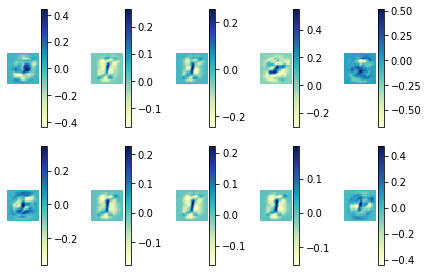

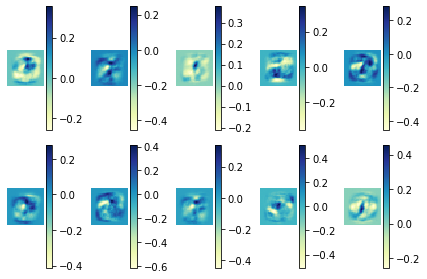


training :: 100%|██████████| 50000/50000 [00:09<00:00, 5367.22it/s]

training :: 100%|██████████| 50000/50000 [00:09<00:00, 5150.82it/s]

training :: 100%|██████████| 50000/50000 [00:09<00:00, 5106.47it/s]

training :: 100%|██████████| 50000/50000 [00:08<00:00, 5869.02it/s]


Weights plots of iteration: 4


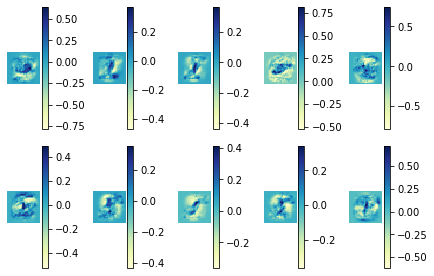

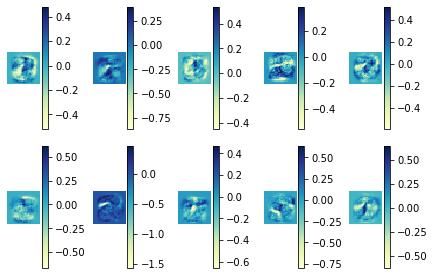


training :: 100%|██████████| 50000/50000 [00:09<00:00, 5005.47it/s]

training :: 100%|██████████| 50000/50000 [00:10<00:00, 4983.81it/s]

training :: 100%|██████████| 50000/50000 [00:08<00:00, 5834.56it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 7048.48it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6717.82it/s]


Weights plots of iteration: 9


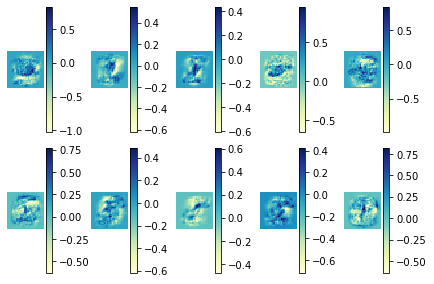

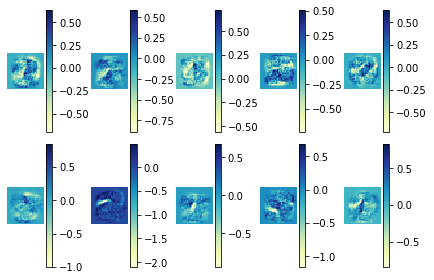


epochs :: 100%|██████████| 10/10 [01:36<00:00,  9.68s/it]


learning rates: 1it [01:36, 96.76s/it]
training ::   1%|          | 597/50000 [00:00<00:08, 5965.28it/s]



---starting run lr 0.001


training :: 100%|██████████| 50000/50000 [00:09<00:00, 5230.57it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6336.60it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6297.78it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6296.27it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6542.07it/s]

training :: 100%|██████████| 50000/50000 [00:08<00:00, 6142.63it/s]

training :: 100%|██████████| 50000/50000 [00:09<00:00, 5218.48it/s]

training :: 100%|██████████| 50000/50000 [00:09<00:00, 5439.37it/s]

training :: 100%|██████████| 50000/50000 [00:08<00:00, 6119.49it/s]

training :: 100%|██████████| 50000/50000 [00:08<00:00, 6232.37it/s]

epochs :: 100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


learning rates: 2it [03:04, 93.99s/it]
training ::   1%|          | 453/50000 [00:00<00:10, 4525.97it/s]



---starting run lr 0.0001


training :: 100%|██████████| 50000/50000 [00:08<00:00, 5793.41it/s]

training :: 100%|██████████| 50000/50000 [00:08<00:00, 5633.29it/s]

training :: 100%|██████████| 50000/50000 [00:09<00:00, 5550.81it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6253.12it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6463.75it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6583.94it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6405.80it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6543.15it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6670.12it/s]

training :: 100%|██████████| 50000/50000 [00:07<00:00, 6677.27it/s]

epochs :: 100%|██████████| 10/10 [01:23<00:00,  8.35s/it]


learning rates: 3it [04:27, 89.27s/it]


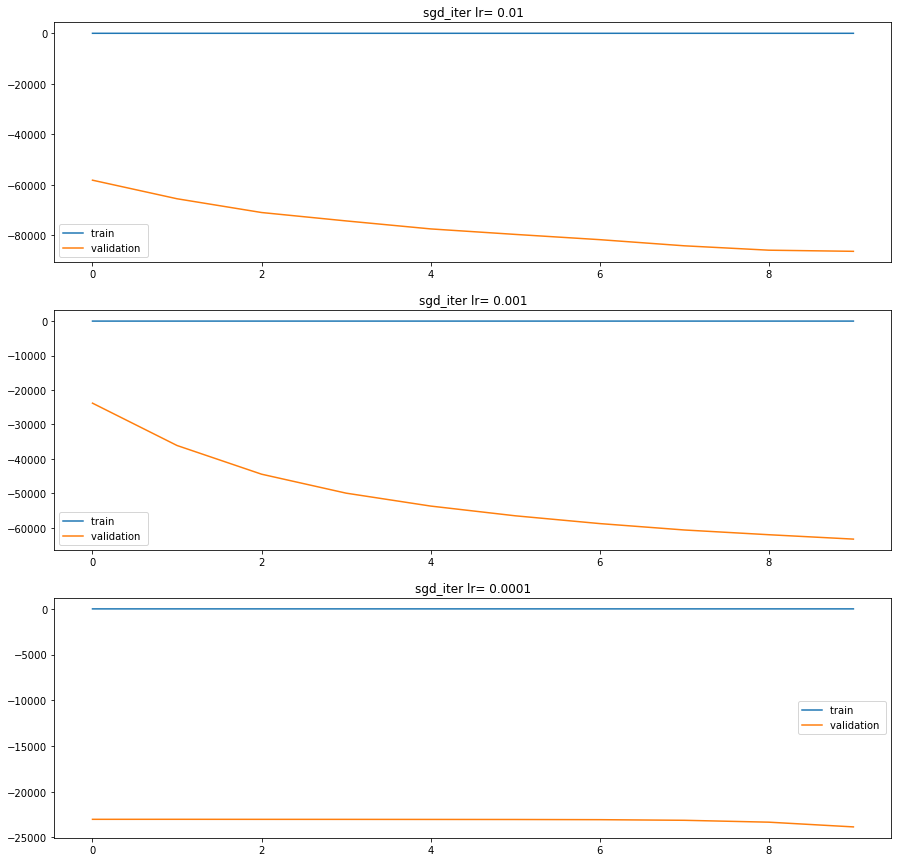

In [101]:
classes = 10
lrs = [1e-2,1e-3,1e-4]
iters = 10
hidden = 20
best = run_test_mlp(lrs, iters, classes, hidden = hidden)

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

We can observe from these graphs that a learning rate of $1e^{-5}$ results in very small steps and does not converge within the 10 iterations. Bigger learning steps are needed in the beginning, as it is the case for $1e^{-4}$ and $1e^-5$, which ensures that indeed the algorithm does converge

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

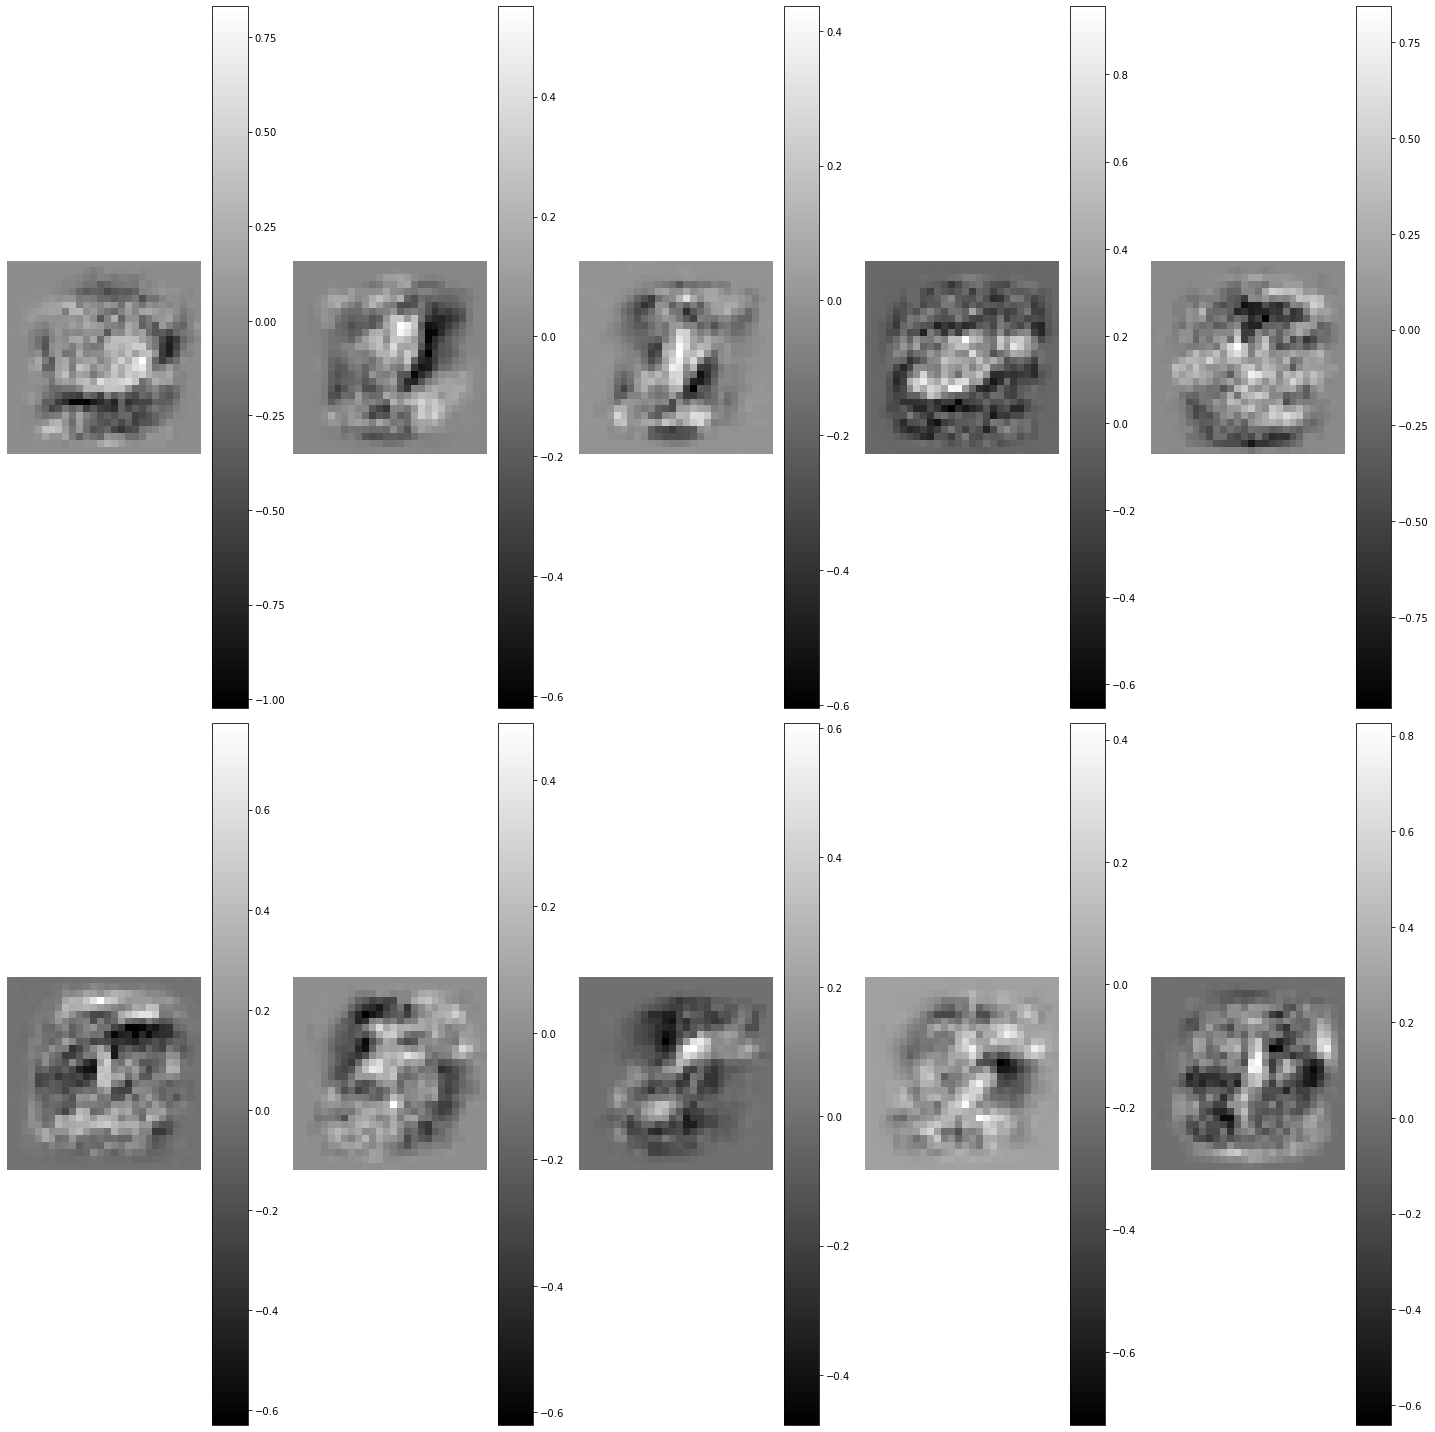

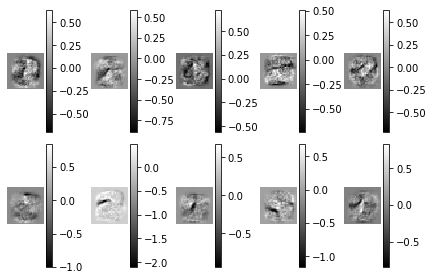

In [104]:
halves = np.split(best[0], 2, 1)
plot_weights(halves, 5)

The model is able to capture more complex dependencies between the input and the output with the help of the hidden layer.

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

The ReLU derivative is 0 for x <0, 1 for x > 0, and undefined at 0.


Tanh is defined as $\frac{e^a  - e^{-a}}{e^a + e ^{-a}}$.

$\frac{\partial \tanh{a}}{\partial a} = 1 - \tanh{(a)}^2$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

> ans
> 1) Centered around 0. This ensures that the algorithm usually convergences faster. Otherwise, maybe bias on gradient direction, which might slow down learning.

>    2) Continuously differentiable (almost) everywhere. Necessary for enabling gradient-based optimization methods

 >   3) Non linearity as the purpose of the activation function is to introduce non-linearity into the network.


In [118]:
def plot(x, title, values):
    
    for value, label, color in values:
        plt.plot(x, value, color, label=label)
    
    plt.xlabel = "x"
    plt.ylabel = "y"
    plt.title( title, fontsize=18, fontweight = "bold")
    
    plt.legend()
    plt.show()
    
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 / ( np.cosh(x) ** 2 )

def sigmoid(x):
    return 1 / ( 1 + np.exp(-x) )

def sigmoid_derivate(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where( x <= 0, 0, 1)

In [119]:
x = np.linspace(-3, 3, 200)

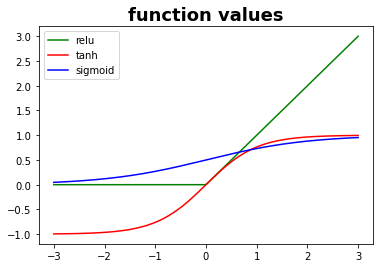

In [120]:
values = [] 

values.append( (relu(x), "relu", "g") )
values.append( (tanh(x), "tanh", "r") )
values.append( (sigmoid(x), "sigmoid", "b") )

plot(x, "function values", values)

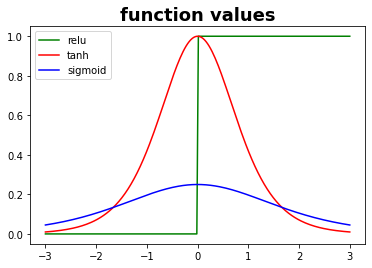

In [121]:
values = [] 

values.append( (relu_derivative(x), "relu", "g") )
values.append( (tanh_derivative(x), "tanh", "r") )
values.append( (sigmoid_derivate(x), "sigmoid", "b") )

plot(x, "function values", values)

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

> Ans
> :: Sigmoid is useful for binary classification, however it suffers from vanishing gradient problem, and it is not zero centered. Tanh is zero centered however it still suffers from the vanishing gradient problem. ReLU   and its variants (leakyReLU) have become very popular as they avoid and rectify the vanishing gradient problem. It suffers from problems such as dead neurons, however its variants such as LeakyReLU solve this issue